In [1]:
!pip install polars -U lightautoml > istallations.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.0.11 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.3.0 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.1.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2024.1.0 which is incompatible.
d

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import os
import time
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import sys
sys.path.append('/kaggle/input/next-orders')
import dataset_class, model, run

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


/kaggle/input/next-orders/run.py
/kaggle/input/next-orders/model.py
/kaggle/input/next-orders/dataset_class.py
/kaggle/input/sbermarket-internship-competition/sample_submission.csv
/kaggle/input/sbermarket-internship-competition/train.csv


In [3]:
def ohe_data(raw: pl.DataFrame) -> pl.DataFrame:
    """
    Вовращает ohe матрицу для категорий.

    Args:
        raw (pl.DataFrame): Polars DataFrame.

    Returns:
        (tpl.DataFrame).
    """

    # OHE 'cart', группировка по юзеру и дате заказа по максимальным значениям
    # Таким образом для каждой категории, если она была в этот день в заказе у пользователя, будет 1
    train_raw = raw.to_dummies(columns='cart').group_by(['user_id', 'order_completed_at']).max()
    train_raw = train_raw.sort(['user_id', 'order_completed_at'])

    return train_raw
    
def sep_history(train_raw: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    Обрабатывает датафрейм polars и возвращает обработынный тренировочный и валидационный датасеты.

    Args:
        raw (pl.DataFrame): Polars DataFrame для обработки.

    Returns:
        tuple[pl.DataFrame, pl.DataFrame]: Обработанные DataFrame для train_data и valid_data.
    """
    
    # Вычисление переменных времени
    train_raw = train_raw.with_columns(pl.col("order_completed_at").str.to_datetime())
    train_raw = train_raw.with_columns(
        [
            (pl.col('user_id').cum_count() - pl.lit(1)).over(['user_id']).alias('order_number'),
            pl.col("order_completed_at").dt.hour().alias("hour"),
            pl.col("order_completed_at").dt.week().alias("week"),
            pl.col("order_completed_at").dt.weekday().alias("weekday"),
            pl.col("order_completed_at").dt.day().alias("day"),
            pl.col("order_completed_at").dt.month().alias("month"),
            pl.col("order_completed_at").dt.year().alias("year"),
        ]
    )
    train_raw = train_raw.drop('order_completed_at')
    
    # Сепарация последнего заказа из истории заказов
    grouped = train_raw.group_by('user_id').agg(pl.max('order_number').alias('max_order_number'))
    merged = train_raw.join(grouped, on='user_id')
    last_order = merged['max_order_number'] == merged['order_number']

    # Разделение на train_data (заказы, кроме последнего) и valid_data (последний заказ) .group_by('user_id').sum()
    train_data = train_raw.filter(~last_order)
    valid_data = train_raw.filter(last_order)

    return train_data, valid_data

def create_dataset(train_data: pl.DataFrame, valid_data: pl.DataFrame) -> pd.DataFrame:
    """
    Компилирует историю заказов (train_data) и последний заказ (valid_data) в укомплектованный тренировочный pd.Dataframe "Train".

    Args:
        train_data (pl.DataFrame): история заказов (корзина на каждого юзера).
        valid_data (pl.DataFrame): последний заказ (корзина на каждого юзера).

    Returns:
        pd.DataFrame: X + Y for model.
    """
    # Преобразование в длинный формат юзера и категории товара
    train_melt = train_data.drop('order_number').melt(id_vars=['user_id', 'hour', 'week', 'weekday', 'day', 'month', 'year'], variable_name='category', value_name='ordered')
    valid_melt = valid_data.drop('order_number', 'hour', 'week', 'weekday', 'day', 'month', 'year').melt(id_vars=['user_id'], variable_name='category', value_name='target')
    
    # Тренировочный датасет
    Train = train_melt
    order_number_df = valid_data.select(['user_id', 'order_number']).unique() # Количество заказов у юзера
    dl_tmp = Train.group_by('category').agg(pl.col(['ordered']).sum()) # Количество заказов по категории
    Train = Train.join(order_number_df, on='user_id', how='left').rename({"order_number": "total_order_num"})
    Train = Train.join(dl_tmp.select('category', 'ordered'), on='category').rename({"ordered_right": "total_order_in_cat"})
    # Вычисление рейтинга для каждой записи
    Train = Train.with_columns(
        [
            (pl.col('ordered') / pl.col('total_order_num')).alias('total_rating'),
            (pl.col('user_id').cast(pl.Utf8) + ';' + pl.col('category')).alias('id')
        ]
    )
    # Вычисление рейтинга по времени
#     rating_per_hour = Train.group_by(
#         ['year', 'month', 'hour', 'user_id'
#         ]
#     ).agg(pl.col("total_rating").mean().alias("rating_per_hour"))
    
#     rating_per_weekday = Train.group_by(
#         ['year', 'month', 'weekday', 'user_id'
#         ]
#     ).agg(pl.col("total_rating").mean().alias("rating_per_weekday"))
    
#     rating_per_day = Train.group_by(
#         ['year', 'month', 'day', 'user_id'
#         ]
#     ).agg(pl.col("total_rating").mean().alias("rating_per_day"))
    
#     rating_per_month = Train.group_by(
#         ['year', 'month', 'user_id'
#         ]
#     ).agg(pl.col("total_rating").mean().alias("rating_per_month"))

#     Train = Train.join(rating_per_month, on=['user_id'])
#     Train = Train.join(rating_per_weekday, on=['user_id'])
#     Train = Train.join(rating_per_day, on=['user_id'])
#     Train = Train.join(rating_per_hour, on=['user_id'])
    
#     # Присоединение целевой переменной из valid_melt к Train
#     Train = Train.join(valid_melt.select('user_id', 'target'), on = 'user_id', how = 'left')

    # Преобразование в pandas DataFrame
    Train = Train.to_pandas()
    Train['id'] = Train['id'].str.replace('cart_', '')
    Train['category'] = Train['category'].str.replace('cart_', '')

    return Train

In [4]:
# tmp импорт в pandas

raw = pd.read_csv('../input/sbermarket-internship-competition/train.csv')
sub = pd.read_csv('../input/sbermarket-internship-competition/sample_submission.csv', sep = ",")

# Приведение столбца 'cart' к int
raw['cart'] = raw['cart'].astype(int)

def filter_raw_data(raw, sub):
    users, carts = zip(*map(lambda x: map(int, x.split(';')), sub['id'].to_numpy()))
    raw = raw[raw['user_id'].isin(users)]
    raw = raw[raw['cart'].isin(carts)]
    return raw

raw = filter_raw_data(raw, sub)

In [ ]:
%%time
raw = pl.from_pandas(raw)
train_raw = ohe_data(raw)
train_data, val_data = sep_history(train_raw)
Train = create_dataset(train_data, val_data)

In [14]:
val_data

user_id,cart_0,cart_1,cart_10,cart_100,cart_101,cart_102,cart_103,cart_104,cart_105,cart_106,cart_107,cart_108,cart_109,cart_11,cart_110,cart_111,cart_112,cart_113,cart_114,cart_115,cart_116,cart_117,cart_118,cart_119,cart_12,cart_120,cart_121,cart_122,cart_123,cart_124,cart_125,cart_126,cart_127,cart_128,cart_129,cart_13,…,cart_865,cart_866,cart_867,cart_868,cart_869,cart_87,cart_870,cart_871,cart_872,cart_873,cart_874,cart_875,cart_876,cart_877,cart_878,cart_879,cart_88,cart_880,cart_89,cart_9,cart_90,cart_91,cart_92,cart_93,cart_94,cart_95,cart_96,cart_97,cart_98,cart_99,order_number,hour,week,weekday,day,month,year
i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i8,i8,i8,i8,i8,i32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,36,3,2,9,2020
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,10,29,2,14,7,2020
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,6,13,26,3,24,6,2020
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,13,35,4,27,8,2020
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,9,35,6,29,8,2020
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10,8,33,2,11,8,2020
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,6,34,3,19,8,2020
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,18,35,5,28,8,2020
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,10,35,6,29,8,2020


In [8]:
train_melt = train_data.drop('order_number', ).melt(id_vars=['user_id', 'hour', 'week', 'weekday', 'day', 'month', 'year'], variable_name='category', value_name='ordered')
valid_melt = val_data.drop('order_number',).melt(id_vars=['user_id', 'hour', 'week', 'weekday', 'day', 'month', 'year'], variable_name='category', value_name='target')

# Тренировочный датасет
# Train = train_melt
# Train = Train.join(train_data.select('user_id', 'hour', ), on = 'user_id')
# order_number_df = valid_data.select(['user_id', 'order_number']).unique() # Количество заказов у юзера
# dl_tmp = Train.group_by('category').agg(pl.col(['ordered']).sum()) # Количество заказов по категории
# Train = Train.join(order_number_df, on='user_id', how='left').rename({"order_number": "total_order_num"})
# Train = Train.join(dl_tmp.select('category', 'ordered'), on='category').rename({"ordered_right": "total_order_in_cat"})
# # Вычисление рейтинга для каждой записи
# Train = Train.with_columns(
#     [
#         (pl.col('ordered') / pl.col('total_order_num')).alias('total_rating'),
#         (pl.col('user_id').cast(pl.Utf8) + ';' + pl.col('category')).alias('id')
#     ]
# )
# print(f'Columns in Train is: {list(Train.columns)}')

In [10]:
train_melt

user_id,hour,week,weekday,day,month,year,category,ordered
i64,i8,i8,i8,i8,i8,i32,str,u8
0,9,29,7,19,7,2020,"""cart_0""",0
0,8,35,1,24,8,2020,"""cart_0""",0
1,16,19,3,8,5,2019,"""cart_0""",0
1,14,3,5,17,1,2020,"""cart_0""",0
1,22,6,4,6,2,2020,"""cart_0""",0
1,13,10,1,2,3,2020,"""cart_0""",0
1,13,13,7,29,3,2020,"""cart_0""",0
1,1,16,2,14,4,2020,"""cart_0""",0
1,17,18,4,30,4,2020,"""cart_0""",0


In [25]:
train_raw

user_id,order_completed_at,cart_0,cart_1,cart_10,cart_100,cart_101,cart_102,cart_103,cart_104,cart_105,cart_106,cart_107,cart_108,cart_109,cart_11,cart_110,cart_111,cart_112,cart_113,cart_114,cart_115,cart_116,cart_117,cart_118,cart_119,cart_12,cart_120,cart_121,cart_122,cart_123,cart_124,cart_125,cart_126,cart_127,cart_128,cart_129,…,cart_865,cart_866,cart_867,cart_868,cart_869,cart_87,cart_870,cart_871,cart_872,cart_873,cart_874,cart_875,cart_876,cart_877,cart_878,cart_879,cart_88,cart_880,cart_89,cart_9,cart_90,cart_91,cart_92,cart_93,cart_94,cart_95,cart_96,cart_97,cart_98,cart_99,order_number,hour,week,weekday,day,month,year
i64,datetime[μs],u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i8,i8,i8,i8,i8,i32
0,2020-07-19 09:59:17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,29,7,19,7,2020
0,2020-08-24 08:55:32,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,35,1,24,8,2020
0,2020-09-02 07:38:25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,36,3,2,9,2020
1,2019-05-08 16:09:41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,19,3,8,5,2019
1,2020-01-17 14:44:23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,3,5,17,1,2020
1,2020-02-06 22:46:55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,22,6,4,6,2,2020
1,2020-03-02 13:43:20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,13,10,1,2,3,2020
1,2020-03-29 13:26:49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,13,13,7,29,3,2020
1,2020-04-14 01:31:20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,16,2,14,4,2020


In [58]:
#     train_raw = train_raw.drop('order_completed_at')
# Tain = pl.from_pandas(Train)
# dl_tmp = Tain.group_by('user_id').agg(pl.col(['ordered']).sum())
# train_raw = train_raw.join(dl_tmp.select('user_id', 'ordered'), on='user_id')
# Группировка по 'user_id' и вычисление максимального номера заказа
grouped = train_raw.group_by('user_id').agg(pl.max('order_number').alias('max_order_number'))

# Присоединение к train_raw для получения максимального номера заказа для каждого 'user_id'
merged = train_raw.join(grouped, on='user_id')

# Определение последнего заказа для каждого пользователя
last_order = merged['max_order_number'] == merged['order_number']

    # Разделение на train_data (заказы, кроме последнего) и valid_data (последний заказ)
train_data = train_raw.filter(~last_order)
valid_data = train_raw.filter(last_order)

In [64]:
valid_data

user_id,order_completed_at,cart_0,cart_1,cart_10,cart_100,cart_101,cart_102,cart_103,cart_104,cart_105,cart_106,cart_107,cart_108,cart_109,cart_11,cart_110,cart_111,cart_112,cart_113,cart_114,cart_115,cart_116,cart_117,cart_118,cart_119,cart_12,cart_120,cart_121,cart_122,cart_123,cart_124,cart_125,cart_126,cart_127,cart_128,cart_129,…,cart_866,cart_867,cart_868,cart_869,cart_87,cart_870,cart_871,cart_872,cart_873,cart_874,cart_875,cart_876,cart_877,cart_878,cart_879,cart_88,cart_880,cart_89,cart_9,cart_90,cart_91,cart_92,cart_93,cart_94,cart_95,cart_96,cart_97,cart_98,cart_99,order_number,hour,week,weekday,day,month,year,ordered
i64,datetime[μs],u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i8,i8,i8,i8,i8,i32,i64
0,2020-09-02 07:38:25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,36,3,2,9,2020,33
1,2020-07-14 10:20:58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,10,29,2,14,7,2020,28
3,2020-06-24 13:07:29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,6,13,26,3,24,6,2020,47
4,2020-08-27 13:54:48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,13,35,4,27,8,2020,101
5,2020-08-29 09:56:56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,9,35,6,29,8,2020,111
7,2020-08-11 08:32:27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10,8,33,2,11,8,2020,86
8,2020-08-19 06:23:55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,6,34,3,19,8,2020,275
9,2020-08-28 18:50:44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,18,35,5,28,8,2020,364
10,2020-08-29 10:58:49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,10,35,6,29,8,2020,15


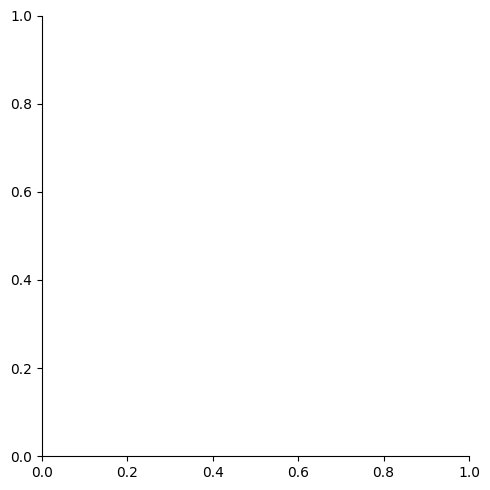

In [10]:
import seaborn as sns

sns.displot()

,user_id,category,ordered,order_number,rating,id,target,total_ordered
0,0,0,0,2,0.000000,0;0,0,16494
1,1,0,0,8,0.000000,1;0,0,16494
2,2,0,1,14,0.071429,2;0,0,16494
3,3,0,0,6,0.000000,3;0,0,16494
4,4,0,0,7,0.000000,4;0,0,16494
...,...,...,...,...,...,...,...,...
17619995,19995,99,0,2,0.000000,19995;99,0,13493
17619996,19996,99,0,2,0.000000,19996;99,0,13493
17619997,19997,99,1,2,0.500000,19997;99,0,13493
17619998,19998,99,0,2,0.000000,19998;99,0,13493


In [106]:
Train_set, Valid_set = train_test_split(Train, test_size = 0.3,
                                        stratify = None, random_state = 23)

In [107]:
%%time 
def f1 (real, pred, **kwargs):
    return f1_score(real, (pred > 0.5).astype(int), **kwargs)

roles = {'target': 'target', 'drop': ['user_id', 'category', 'id']}
task = Task('binary', metric = f1)

automl = TabularAutoML(task = task, 
                       timeout = 300,
                       cpu_limit = 4,
                       reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 23},
                       general_params = {'use_algos': [['linear_l2']]},
                      )
train_pred = automl.fit_predict(Train_set, roles = roles)
print('Score', "%.5f" % f1(Train_set.target, train_pred.data))

valid_pred = automl.predict(Valid_set)
print('Score on out of folds validation', "%.5f" % f1(Valid_set.target, valid_pred.data))

Score 0.30853
Score on out of folds validation 0.30751
CPU times: user 1min 59s, sys: 58.5 s, total: 2min 58s
Wall time: 1min 22s


In [108]:
best_score = 0
for i in np.arange(0.01, 1.0, 0.01):
    score = f1 = f1_score(Valid_set.target, (valid_pred.data > i).astype(int))
    if score > best_score:
        best_score = score
        proba_split = i

print('At i =', "%.2f" % proba_split,'score is : ' "%.5f" % best_score)

At i = 0.12 score is : 0.40421


In [49]:
Train

,user_id,category,ordered,order_number,rating,id,target,total_ordered
0,0,0,0,2,0.0,0;0,0,12922
1,1,0,0,8,0.0,1;0,0,12922
2,3,0,0,6,0.0,3;0,0,12922
3,4,0,0,7,0.0,4;0,0,12922
4,5,0,0,14,0.0,5;0,0,12922
...,...,...,...,...,...,...,...,...
11184883,19994,99,0,4,0.0,19994;99,0,10373
11184884,19995,99,0,2,0.0,19995;99,0,10373
11184885,19996,99,0,2,0.0,19996;99,0,10373
11184886,19997,99,1,2,0.5,19997;99,0,10373


In [65]:
Test = Train.copy()
Test['order_number'] += 1 
Test['ordered'] = Test['ordered'] + Test['target']
test_total_ordered = Test.groupby('category')['ordered'].sum()
Test['total_ordered'] = Test['category'].map(test_total_ordered)
Test['rating'] = Test['ordered'] / Test['order_number']
Test = Test.drop('target', axis=1)
Test.head(3)

,user_id,category,ordered,order_number,rating,id,total_ordered
0,0,0,0,3,0.000000,0;0,18387
1,1,0,0,9,0.000000,1;0,18387
2,2,0,1,15,0.066667,2;0,18387


In [66]:
predictions = automl.predict(Test)
print('Train target mean:', "%.5f" % Train.target.mean())
print('Test target mean:', "%.5f" % (predictions.data > 0.5).astype(int).mean())

Train target mean: 0.01595
Test target mean: 0.00681


In [67]:
th = 0.5
train_mean = Train.target.mean()
test_mean = (predictions.data > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (predictions.data > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('Train mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

Threshold: 0.1600
Train mean: 0.01595
New Test mean: 0.01605


In [95]:
Test['target'] = (predictions.data > th).astype(int)
submit = pd.merge(sub['id'], Test[['id', 'target']], on='id')

In [94]:
import csv

with open('submission.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(submit.columns)
    for row in submit.values:
        csvwriter.writerow(row)

In [91]:
submit

,id,target
0,0;133,0
1,0;5,0
2,0;10,0
3,0;396,0
4,0;14,1
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,0
790447,19998;798,0
